# Encode graph's edges into a Wave-Function

### Load the Libraries needed

In [1]:
import json                       # Read and write files in json
import numpy as np                # Matrix operations
import qiskit as q
from pprint import pprint         # Pretty printing of matrices
from math import log2, ceil, floor

# Load the Graph and make it Unweighted

In [2]:
file_path = "test_graph.json"

In [3]:
with open(file_path, "r") as f:
    graph = json.load(f)
pprint(graph)

[[[1, 0.901], [2, 0.464], [3, 0.197]],
 [[0, 0.901], [2, 0.416], [4, 0.94], [5, 0.665]],
 [[0, 0.464], [1, 0.416], [3, 0.05], [6, 0.224]],
 [[0, 0.197], [2, 0.05], [4, 0.57], [6, 0.028]],
 [[1, 0.94], [3, 0.57], [5, 0.898], [6, 0.931]],
 [[1, 0.665], [4, 0.898]],
 [[2, 0.224], [3, 0.028], [4, 0.931]]]


In [4]:
n_of_vertices = len(graph)

In [5]:
# Convert the graph in a list of triples in the form (start, end, weight)
graph = [(start, v[0]) for start, value in enumerate(graph) for v in value]
pprint(graph)

[(0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 2),
 (1, 4),
 (1, 5),
 (2, 0),
 (2, 1),
 (2, 3),
 (2, 6),
 (3, 0),
 (3, 2),
 (3, 4),
 (3, 6),
 (4, 1),
 (4, 3),
 (4, 5),
 (4, 6),
 (5, 1),
 (5, 4),
 (6, 2),
 (6, 3),
 (6, 4)]


# Initialize the Qbits registers and their subsets

In [6]:
n_of_bits = ceil(log2(max((e[0] for e in graph))))
print("To encode the edges we need %d qbits per nodes"%n_of_bits)

To encode the edges we need 3 qbits per nodes


In [7]:
start = q.QuantumRegister(n_of_bits, name="s")
end = q.QuantumRegister(n_of_bits, name ="e")

In [8]:
# We will and in a tree fashion the values so we need and in a tree with n leafes we have n-1 internal nodes
aux_dim = 2*n_of_bits - 1
aux = q.QuantumRegister(aux_dim, name="a")

In [9]:
reg = [v for register in [start,end] for v in register]
reg_dim = len(reg)

In [10]:
qbits = [v for register in [start,end,aux] for v in register]
n_of_total_qbits = len(qbits)

# Create the Circuit

In [11]:
circuit = q.QuantumCircuit(start,end,aux)

# Initialize the edge qbits with an Hadamard gate

In [12]:
for r in reg:
    circuit.h(r)

In [13]:
# Print the circuit
circuit.draw(output="mpl")

<Figure size 334.444x944.806 with 1 Axes>

# State encode the edge as the concatenation of the binary rappresentation of the nodes

In [14]:
edge_binary_encoding = ["{:03b}".format(e[0]) + "{:03b}".format(e[1]) for e in graph]
pprint(edge_binary_encoding)
print("# of edges %d"%(len(edge_binary_encoding)))

['000001',
 '000010',
 '000011',
 '001000',
 '001010',
 '001100',
 '001101',
 '010000',
 '010001',
 '010011',
 '010110',
 '011000',
 '011010',
 '011100',
 '011110',
 '100001',
 '100011',
 '100101',
 '100110',
 '101001',
 '101100',
 '110010',
 '110011',
 '110100']
# of edges 24


# Create the Superposition that have all states with equal probability but with the one which are edges have negative phase

In [15]:
def encode_edge(circuit, edge):
    circuit.barrier()
    ###################################################################
    # Setup
    ###################################################################
    # Add nots if the qbit must be 0 since we have to do an AND
    for i, (b_0, b_1) in enumerate(zip(edge[::2],edge[1::2])):
        if b_0 == '0':
            circuit.x(reg[2*i])
        if b_1 == '0':
            circuit.x(reg[(2*i)+1])
            
    ###################################################################
    # And of all qbits
    ###################################################################
            
    # And togheather the aux qbits
    and_index = 0
    result_index = ceil(n_of_total_qbits/2)
    
    while and_index < result_index-1:
        circuit.ccx(qbits[and_index],qbits[and_index+1], qbits[result_index])
        and_index += 2
        result_index += 1

    ###################################################################
    # Phase change
    ###################################################################
    
    # Change the phase of the 
    if edge[-1] == '0':
        circuit.x(end[len(end)-1])
        circuit.cz(aux[len(aux)-1], end[len(end)-1])
        circuit.x(end[len(end)-1])
    else:
        circuit.cz(aux[len(aux)-1], end[len(end)-1])
    
    ###################################################################
    # Clean the qbits
    ###################################################################
    
    # Clear the values
    and_index = n_of_total_qbits - 3
    result_index = n_of_total_qbits - 1
    
    while and_index >= 0:
        circuit.ccx(qbits[and_index],qbits[and_index+1], qbits[result_index])
        and_index -= 2
        result_index -= 1
    
    ###################################################################
    # Reverse the Setup
    ###################################################################
    
    # Add nots if the qbit must be 0 since we have to do an AND
    for i, (b_0, b_1) in enumerate(zip(edge[::2],edge[1::2])):
        if b_1 == '0':
            circuit.x(reg[(2*i)+1])
        if b_0 == '0':
            circuit.x(reg[2*i])
            
    return circuit

In [16]:
circuit = encode_edge(circuit, edge_binary_encoding[0])

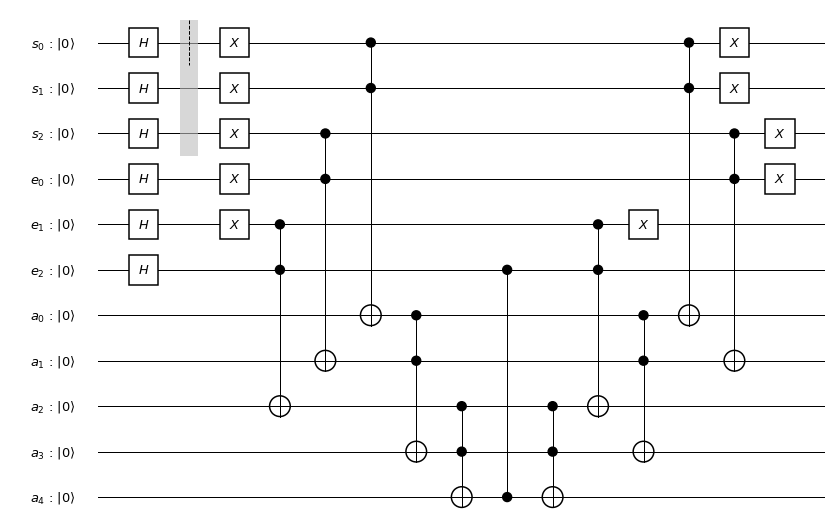

In [17]:
circuit.draw(output="mpl")

In [18]:
print("# of Gates %d"%circuit.size())
print("Depth %d"%circuit.depth())

# of Gates 28
Depth 11


In [19]:
for edge in edge_binary_encoding[1:]:
    circuit = encode_edge(circuit, edge)

 # Print the Result

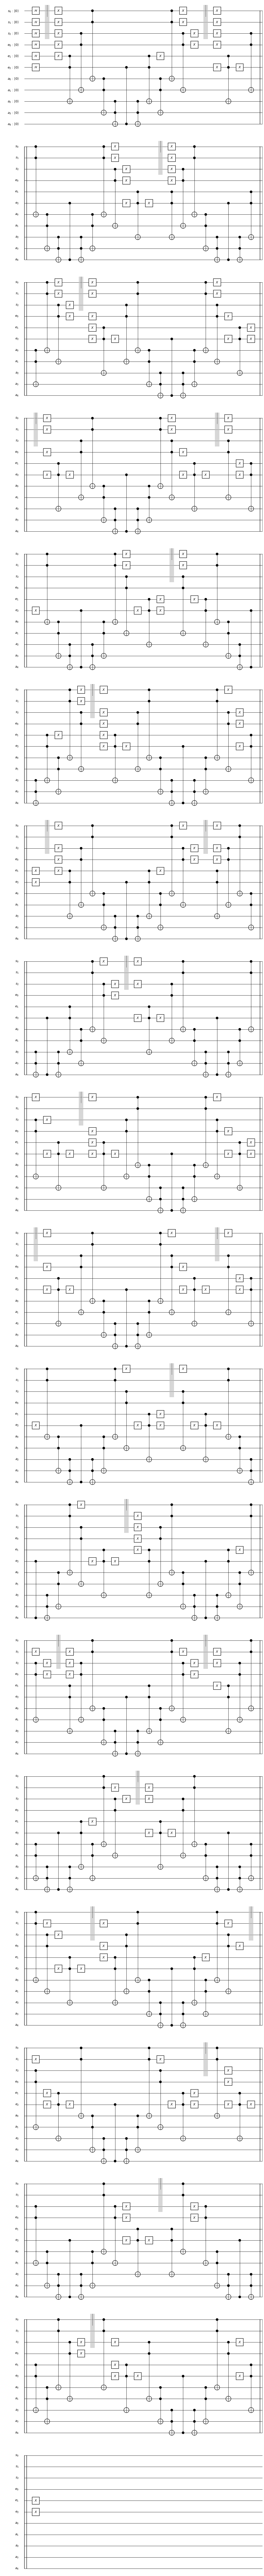

In [20]:
circuit.draw(output="mpl")

# Simulate the circuit Symbolically to get the wave-function of the 6 main qbits for sanity check

In [21]:
print("# of Gates %d"%circuit.size())
print("Depth %d"%circuit.depth())

# of Gates 490
Depth 241


In [22]:
backend_sim = q.BasicAer.get_backend('statevector_simulator')
result = q.execute(circuit, backend_sim).result()

In [23]:
main_wave_function = list(result.get_statevector(circuit))[:64]

print("If the system works, all the True must have a negative value and all the False must be positive")

for index, value in enumerate(main_wave_function):
    encoding = ''.join(reversed("{:06b}".format(index)))
    if encoding in edge_binary_encoding:
        print(value.real, encoding, encoding in edge_binary_encoding)
        
print("~"*64)

for index, value in enumerate(main_wave_function):
    encoding = ''.join(reversed("{:06b}".format(index)))
    if encoding not in edge_binary_encoding:
        print(value.real, encoding, encoding in edge_binary_encoding)

If the system works, all the True must have a negative value and all the False must be positive
0.12499999999999903 010000 True
0.12499999999999847 001000 True
0.12499999999999886 011000 True
0.12499999999999933 110100 True
0.12499999999999943 001100 True
0.12499999999999911 101100 True
0.12499999999999897 011100 True
0.12499999999999899 000010 True
0.12499999999999908 110010 True
0.12499999999999885 001010 True
0.12499999999999911 011010 True
0.1249999999999995 100110 True
0.12499999999999936 010110 True
0.12499999999999925 011110 True
-0.12499999999999911 000001 True
-0.12499999999999897 100001 True
-0.12499999999999908 010001 True
-0.12499999999999942 101001 True
-0.12499999999999942 100101 True
-0.12499999999999903 001101 True
-0.12499999999999928 000011 True
-0.12499999999999928 100011 True
-0.12499999999999929 010011 True
-0.12499999999999933 110011 True
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.12499999999999865 000000 False
0.12499999999999832 100000 Fa

# Grover's Iteration

In [24]:
circuit.barrier()
###################################################################
# H Col
###################################################################
for r in reg:
    circuit.h(r)
###################################################################
# X Col
###################################################################
# Add nots if the qbit must be 0 since we have to do an AND
for r in reg:
    circuit.x(r)
    
###################################################################
# And of all qbits
###################################################################

# And togheather the aux qbits
and_index = 0
result_index = ceil(n_of_total_qbits/2)

while and_index < result_index-1:
    circuit.ccx(qbits[and_index],qbits[and_index+1], qbits[result_index])
    and_index += 2
    result_index += 1

###################################################################
# Phase change
###################################################################

circuit.x(end[len(end)-1])
circuit.cz(aux[len(aux)-1], end[len(end)-1])
circuit.x(end[len(end)-1])

###################################################################
# Clean the qbits
###################################################################

# Clear the values
and_index = n_of_total_qbits - 3
result_index = n_of_total_qbits - 1

while and_index >= 0:
    circuit.ccx(qbits[and_index],qbits[and_index+1], qbits[result_index])
    and_index -= 2
    result_index -= 1

###################################################################
# X Col
###################################################################
# Add nots if the qbit must be 0 since we have to do an AND
for r in reg:
    circuit.x(r)
###################################################################
# H Col
###################################################################
for r in reg:
    circuit.h(r)

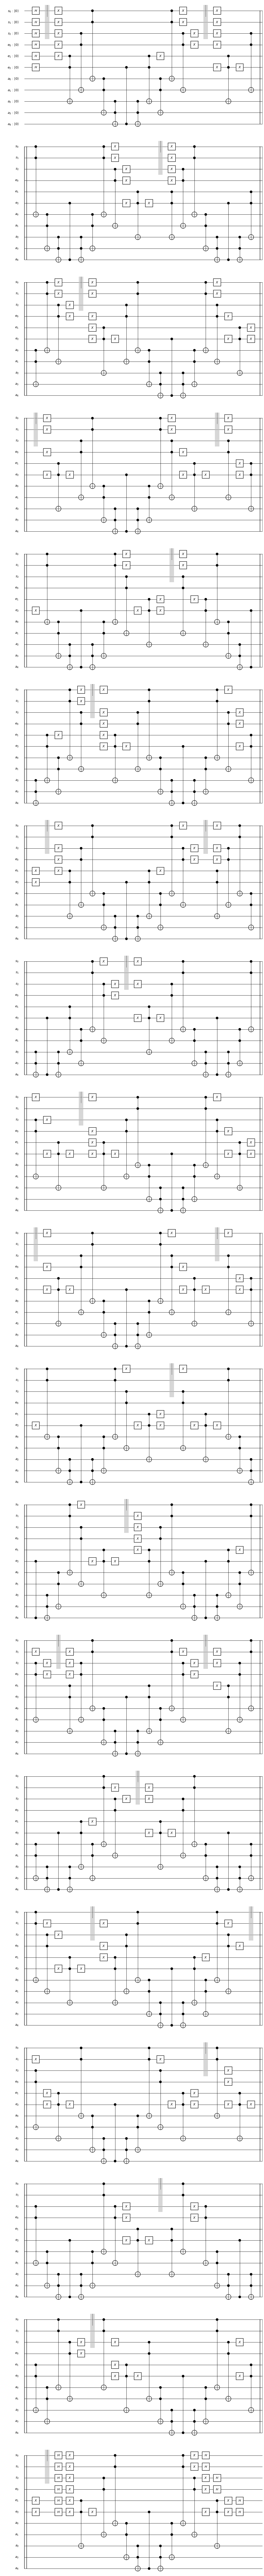

In [25]:
circuit.draw(output="mpl")

In [26]:
print("# of Gates %d"%circuit.size())
print("Depth %d"%circuit.depth())

# of Gates 528
Depth 253


# Measure the Output

In [27]:
cstart = q.ClassicalRegister(n_of_bits, 'cs')
cend   = q.ClassicalRegister(n_of_bits, 'ce')
circuit.add_register(cstart)
circuit.add_register(cend)

In [28]:
circuit.barrier()
circuit.measure(start, cstart)
circuit.measure(end, cend)

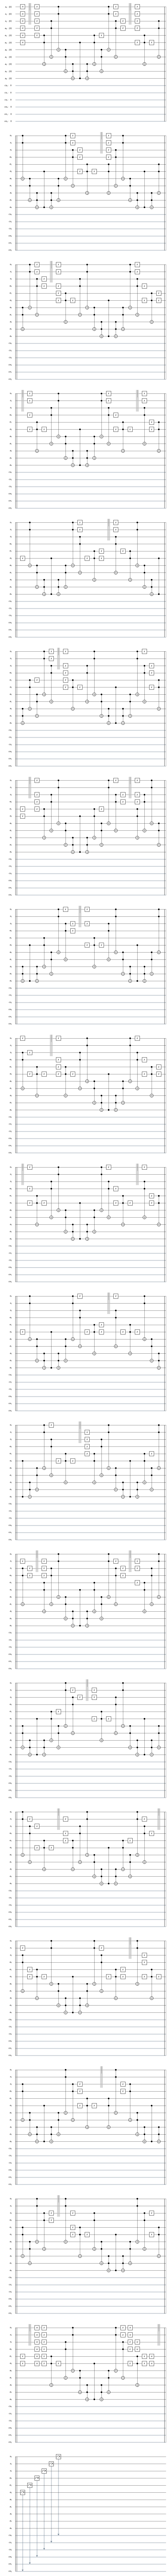

In [29]:
circuit.draw(output="mpl")

In [30]:
print("# of Gates %d"%circuit.size())
print("Depth %d"%circuit.depth())

# of Gates 535
Depth 255


# Actually Simulate the computation 1024 times

In [31]:
backend_sim = q.BasicAer.get_backend('qasm_simulator')
result = q.execute(circuit, backend_sim).result()
counts = result.get_counts(circuit)
pprint(counts)

{'000 000': 17,
 '000 001': 16,
 '000 010': 18,
 '000 011': 16,
 '000 100': 11,
 '000 101': 16,
 '000 110': 18,
 '000 111': 16,
 '001 000': 9,
 '001 001': 18,
 '001 010': 14,
 '001 011': 20,
 '001 100': 15,
 '001 101': 10,
 '001 110': 15,
 '001 111': 11,
 '010 000': 21,
 '010 001': 17,
 '010 010': 17,
 '010 011': 19,
 '010 100': 16,
 '010 101': 16,
 '010 110': 19,
 '010 111': 19,
 '011 000': 17,
 '011 001': 18,
 '011 010': 16,
 '011 011': 19,
 '011 100': 15,
 '011 101': 12,
 '011 110': 19,
 '011 111': 18,
 '100 000': 20,
 '100 001': 20,
 '100 010': 12,
 '100 011': 15,
 '100 100': 12,
 '100 101': 17,
 '100 110': 17,
 '100 111': 25,
 '101 000': 16,
 '101 001': 11,
 '101 010': 14,
 '101 011': 14,
 '101 100': 20,
 '101 101': 17,
 '101 110': 13,
 '101 111': 19,
 '110 000': 15,
 '110 001': 20,
 '110 010': 14,
 '110 011': 10,
 '110 100': 16,
 '110 101': 16,
 '110 110': 7,
 '110 111': 16,
 '111 000': 12,
 '111 001': 15,
 '111 010': 16,
 '111 011': 22,
 '111 100': 10,
 '111 101': 21,
 '111 110'

In [32]:
values = []
for key, item in counts.items():
    key = key.replace(" ","")
    works = key in edge_binary_encoding
    values.append((key,item, works))
    
values.sort(key=lambda x: -x[1])

for v in values:
    print("%s %02d %s"%v)
    

100111 25 False
111011 22 False
111101 21 False
010000 21 True
110001 20 False
100000 20 False
101100 20 True
111110 20 False
100001 20 True
001011 20 False
010011 19 True
011110 19 True
011011 19 False
010111 19 False
101111 19 False
010110 19 True
000010 18 True
011111 18 False
000110 18 False
011001 18 False
001001 18 False
100110 17 True
100101 17 True
010010 17 False
000000 17 False
011000 17 True
010001 17 True
101101 17 False
110100 16 True
110101 16 False
110111 16 False
010100 16 False
011010 16 True
101000 16 False
111010 16 False
000011 16 True
000001 16 True
000101 16 False
000111 16 False
010101 16 False
110000 15 False
111001 15 False
100011 15 True
001100 15 True
001110 15 False
011100 15 True
001010 14 True
101010 14 False
111111 14 False
101011 14 False
110010 14 True
101110 13 False
100100 12 False
111000 12 False
100010 12 False
011101 12 False
101001 11 True
001111 11 False
000100 11 False
111100 10 False
110011 10 True
001101 10 True
001000 09 True
110110 07 False
